In [4]:
import random
import matplotlib.pyplot as plt
import networkx as nx

**The Plan**
- Define a super simple MDP. Start without any cycles, literally just make it a directed acyclic graph.
- Assign random numbers to all state-action pairs in this MDP (e.g. sampled from a gaussian with mean 0, variance 1), i.e. a maximally dense reward function.
- Write a function which computes the set of optimal policies assuming that those numbers are interpreted as a reward function.
- Generate many (e.g. 1000) random reward functions, and check that the optimal policies they lead to are non-uniform, i.e. some policies are more likely than others to be generated via this process.

Hypotheses: (speculative)
- Some policies will be more likely than others to be generated (what structure in particular?)

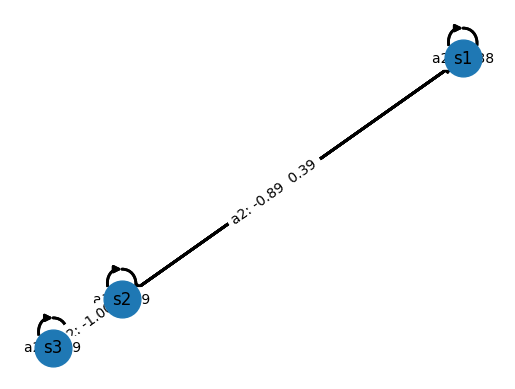

Optimal Policy: {'s1': 'a1', 's2': 'a1', 's3': 'a1'}


In [11]:
### Defining a markov decision process
### Thanks ChatGPT (again)

import numpy as np

class MDP:
    def __init__(self, states, actions, transition_function, reward_function, gamma):
        self.states = states
        self.actions = actions
        self.transition_function = transition_function  # Function: (s, a, s') -> Probability
        self.reward_function = reward_function  # Function: (s, a, s') -> Reward, now passed during initialization
        self.gamma = gamma

    def get_possible_actions(self, state):
        return self.actions

    def transition(self, state, action):
        return [(self.transition_function(state, action, next_state),
                 next_state,
                 self.reward_function(state, action, next_state))
                for next_state in self.states]

    def compute_optimal_policy(self, epsilon=0.01, max_iterations=1000):
        values = {state: 0 for state in self.states}
        policy = {state: None for state in self.states}

        for _ in range(max_iterations):
            delta = 0
            for state in self.states:
                v = values[state]
                action_values = [sum(p * (reward + self.gamma * values[next_state])
                                     for p, next_state, reward in self.transition(state, action))
                                 for action in self.get_possible_actions(state)]
                values[state] = max(action_values)
                delta = max(delta, abs(v - values[state]))
            if delta < epsilon:
                break

        for state in self.states:
            action_values = {action: sum(p * (reward + self.gamma * values[next_state])
                                          for p, next_state, reward in self.transition(state, action))
                             for action in self.get_possible_actions(state)}
            policy[state] = max(action_values, key=action_values.get)

        return policy

    def plot_graph(self):
        G = nx.MultiDiGraph()
        
        # Add nodes for each state
        for state in self.states:
            G.add_node(state)
        
        # Add edges for each action and transition
        for state in self.states:
            for action in self.actions:
                for next_state in self.states:
                    # Assuming deterministic transitions for simplicity
                    if self.transition_function(state, action, next_state) > 0:
                        reward = self.reward_function(state, action, next_state)
                        G.add_edge(state, next_state, action=action, weight=reward)
        
        pos = nx.spring_layout(G)  # Positions for all nodes
        nx.draw_networkx_nodes(G, pos, node_size=700)
        nx.draw_networkx_labels(G, pos)
        
        # Draw edges with different styles for different actions if needed
        for edge in G.edges(data=True):
            nx.draw_networkx_edges(G, pos, edgelist=[(edge[0], edge[1])], width=2, label=f"{edge[2]['action']}: {edge[2]['weight']:.2f}")
        
        edge_labels = dict([((u, v,), f"{d['action']}: {d['weight']:.2f}")
                            for u, v, d in G.edges(data=True)])
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        
        plt.axis('off')
        plt.show()


# Define a reward function that assigns random rewards for each state-action pair
def random_reward_function(states, actions):
    """Initializes a reward function that assigns random rewards to state-action pairs."""
    rewards = {}
    for state in states:
        for action in actions:
            for next_state in states:
                rewards[(state, action, next_state)] = np.random.normal(0, 1)  # Gaussian distribution, mean=0, variance=1
    return lambda s, a, s_prime: rewards[(s, a, s_prime)]

# Example MDP setup
states = ['s1', 's2', 's3']
actions = ['a1', 'a2']
transition_function = lambda s, a, s_prime: 0.5  # Simplified for demonstration
gamma = 0.9

# Create an MDP object with the randomized reward function
mdp = MDP(states, actions, transition_function, random_reward_function(states, actions), gamma)
optimal_policy = mdp.compute_optimal_policy()
mdp.plot_graph()
print("Optimal Policy:", optimal_policy)

In [7]:
### Oops, there's already a function for this in the mdptoolbox library
import mdptoolbox, mdptoolbox.example
import numpy as np

# Generate a simple example MDP problem
P, R = mdptoolbox.example.forest(S=3, r1=4, r2=2, p=0.1)

# P is the transition probability matrix
# P[action][state, nextState] = probability of transitioning from state to nextState given action
# R is the reward matrix
# R[state, action] = reward received when taking action in state

# Initialize the Value Iteration algorithm
vi = mdptoolbox.mdp.ValueIteration(P, R, 0.9)

# Run the Value Iteration algorithm
vi.run()

# Output results
print("Policy:", vi.policy)  # Best action in each state
print("Value:", vi.V)  # Value of each state


Policy: (0, 0, 0)
Value: (5.051970000000001, 8.291970000000001, 12.291970000000001)


In [12]:
### Test 1000 reward functions, see what policies we get

NUM_REWARD_FUNCTIONS = 1000
states = ['s1', 's2', 's3']
actions = ['a1', 'a2']
transition_function = lambda s, a, s_prime: 0.5  # Simplified for demonstration
gamma = 0.9
random_reward_functions = [random_reward_function(states, actions) for _ in range(NUM_REWARD_FUNCTIONS)]

mdps = [MDP(states, actions, transition_function, reward_function, gamma) for reward_function in random_reward_functions]
optimal_policies = [mdp.compute_optimal_policy() for mdp in mdps]
print("Optimal Policies:", optimal_policies)

Optimal Policies: [{'s1': 'a1', 's2': 'a1', 's3': 'a1'}, {'s1': 'a1', 's2': 'a1', 's3': 'a1'}, {'s1': 'a1', 's2': 'a1', 's3': 'a1'}, {'s1': 'a1', 's2': 'a1', 's3': 'a1'}, {'s1': 'a1', 's2': 'a1', 's3': 'a1'}, {'s1': 'a1', 's2': 'a1', 's3': 'a1'}, {'s1': 'a1', 's2': 'a1', 's3': 'a1'}, {'s1': 'a1', 's2': 'a1', 's3': 'a1'}, {'s1': 'a1', 's2': 'a1', 's3': 'a1'}, {'s1': 'a1', 's2': 'a1', 's3': 'a1'}, {'s1': 'a1', 's2': 'a1', 's3': 'a1'}, {'s1': 'a1', 's2': 'a1', 's3': 'a1'}, {'s1': 'a1', 's2': 'a1', 's3': 'a1'}, {'s1': 'a1', 's2': 'a1', 's3': 'a1'}, {'s1': 'a1', 's2': 'a1', 's3': 'a1'}, {'s1': 'a1', 's2': 'a1', 's3': 'a1'}, {'s1': 'a1', 's2': 'a1', 's3': 'a1'}, {'s1': 'a1', 's2': 'a1', 's3': 'a1'}, {'s1': 'a1', 's2': 'a1', 's3': 'a1'}, {'s1': 'a1', 's2': 'a1', 's3': 'a1'}, {'s1': 'a1', 's2': 'a1', 's3': 'a1'}, {'s1': 'a1', 's2': 'a1', 's3': 'a1'}, {'s1': 'a1', 's2': 'a1', 's3': 'a1'}, {'s1': 'a1', 's2': 'a1', 's3': 'a1'}, {'s1': 'a1', 's2': 'a1', 's3': 'a1'}, {'s1': 'a1', 's2': 'a1', 's3': 